## Reinforcement Learning from Human Feedback Using PPO

In [1]:
!pip uninstall -y trl transformers peft diffusers

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
Found existing installation: diffusers 0.34.0
Uninstalling diffusers-0.34.0:
  Successfully uninstalled diffusers-0.34.0


In [2]:
!pip install transformers==4.36.2
!pip install peft==0.10.0
!pip install trl==0.7.10

!pip install --user torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0 --extra-index-url https://download.pytorch.org/whl/cu121
!pip install --user datasets==3.2.0
!pip install --user nltk==3.9.1 rouge_score==0.1.2
!pip install --user matplotlib==3.10.0
!pip install numpy==1.26.0

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from tqdm import tqdm
import pandas as pd
tqdm.pandas()

from transformers import pipeline, AutoTokenizer,AutoModelForCausalLM
from datasets import load_dataset
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
import os
import tarfile
import pickle
import json
import matplotlib.pyplot as plt
import torch
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

### Helper Functions

In [3]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

In [4]:
def pad_sequence_to_length(tensor, length, pad_token_id):
    # tensor.size(0): Get the size of the first dimension
    padding_length = length - tensor.size(0)
    if padding_length > 0:
        padding = torch.full((padding_length,), pad_token_id, dtype=torch.long, device=tensor.device)
        return torch.cat((tensor, padding))
    return tensor

def pad_list_to_batch_size(tensors, batch_size, pad_token_id):
    max_length = max(t.size(0) for t in tensors)
    padded_tensors = [pad_sequence_to_length(t, max_length, pad_token_id) for t in tensors]
    while len(padded_tensors) < batch_size:
        padded_tensors.append(torch.full((max_length,), pad_token_id, dtype=torch.long, device=tensors[0].device))

    return padded_tensors[:batch_size]

In [5]:
def print_ppo_stats(stats, related_to_objective=False):
    print("PPO Training Statistics\n")

    if related_to_objective:
        print("Objective Statistics:")
        print(f"  KL Divergence (objective/kl): {stats['objective/kl']}")
        print(f"  KL Coefficient (objective/kl_coef): {stats['objective/kl_coef']}")
        print(f"  Entropy (objective/entropy): {stats['objective/entropy']}\n")

        print("PPO Losses (Related to Minimizing Objective Function):")
        print(f"  Policy Loss (ppo/loss/policy): {stats['ppo/loss/policy']}")
        print(f"  Value Loss (ppo/loss/value): {stats['ppo/loss/value']}")
        print(f"  Total Loss (ppo/loss/total): {stats['ppo/loss/total']}\n")

        print("PPO Policy Statistics:")
        print(f"  Policy Entropy (ppo/policy/entropy): {stats['ppo/policy/entropy']}")
        print(f"  Approx KL (ppo/policy/approxkl): {stats['ppo/policy/approxkl']}")
        print(f"  Clip Fraction (ppo/policy/clipfrac): {stats['ppo/policy/clipfrac']}\n")
    else:
        print("Reward and Value Function Estimation:")
        print(f"  Mean Non-Score Reward (ppo/mean_non_score_reward): {stats['ppo/mean_non_score_reward']}")
        print(f"  Mean Scores (ppo/mean_scores): {stats['ppo/mean_scores']}")
        print(f"  Std Scores (ppo/std_scores): {stats['ppo/std_scores']}")
        print(f"  Value Prediction (ppo/val/vpred): {stats['ppo/val/vpred']}")
        print(f"  Value Prediction Error (ppo/val/error): {stats['ppo/val/error']}")
        print(f"  Value Prediction Variance (ppo/val/var): {stats['ppo/val/var']}")
        print(f"  Value Prediction Mean (ppo/val/mean): {stats['ppo/val/mean']}")
        print(f"  Explained Variance (ppo/val/var_explained): {stats['ppo/val/var_explained']}\n")

    print("Token Lengths:")
    print(f"  Queries Length Mean (tokens/queries_len_mean): {stats['tokens/queries_len_mean']}")
    print(f"  Responses Length Mean (tokens/responses_len_mean): {stats['tokens/responses_len_mean']}\n")

    print("Time Statistics:")
    print(f"  Total Time (time/ppo/total): {stats['time/ppo/total']} seconds\n")

### Initializing the PPO configuration, model, and tokenizer

In [6]:
config = PPOConfig(model_name="lvwerra/gpt2-imdb", learning_rate=1.41e-5)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

### Dataset and dataset tokenization

In [7]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8,tokenizer=tokenizer):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    # tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    # tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [8]:
dataset = build_dataset(config)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


### Collator function

In [9]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

### Initialize PPOTrainer

In [10]:
ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

In [11]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Reward function

The sentiment analysis pipeline serves as a reward function. By analyzing the sentiment of each response and assigning a reward based on the sentiment score, the PPO Trainer can optimize the chatbot’s policy to generate more positively received and engaging responses.

In [12]:
sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)
sent_kwargs = {"top_k":None, "function_to_apply": "none", "batch_size": 2}

text = "this movie was really bad!!"
sentiment_pipe(text, **sent_kwargs)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 2.335047721862793},
 {'label': 'POSITIVE', 'score': -2.7265756130218506}]

### Generating responses using PPO

In [13]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": 50256}

sentiment = "POSITIVE"

In [ ]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]
    print(f"epoch {epoch}")

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    positive_scores = [item["score"] for output in pipe_outputs for item in output if item["label"] == sentiment]
    rewards = [torch.tensor(score) for score in positive_scores]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    all_stats.append(stats)

In [ ]:
# Save the model

model_dir = "ppo-good"
os.makedirs(model_dir, exist_ok=True)

# Save model configuration and weights
model_1.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

OR exactly the same:

In [14]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz

--2025-07-29 12:07:25--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21193579 (20M) [binary/octet-stream]
Saving to: ‘ppo-good.pkl’

ppo-good.pkl        100%[===================>]  20.21M  63.5MB/s    in 0.3s    

2025-07-29 12:07:26 (63.5 MB/s) - ‘ppo-good.pkl’ saved [21193579/21193579]

--2025-07-29 12:07:26--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
C

In [15]:
file_name = "ppo-good-tar.gz"
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

model_dir = "ppov3new1"
model_1 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
file_name = "ppo-good.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_1.to(device)

Some weights of the model checkpoint at ppov3new1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (

### Plotting PPO training loss and mean

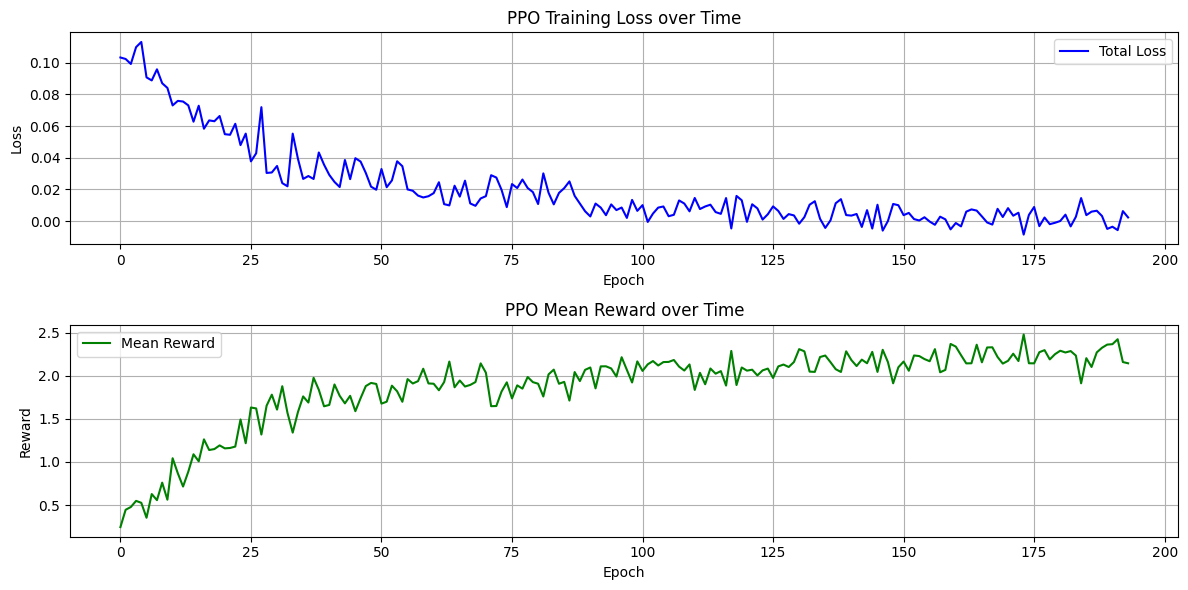

In [17]:
loss_values = [stat['ppo/loss/total'] for stat in all_stats]
reward_values = [stat['ppo/mean_scores'] for stat in all_stats]

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_values, label='Total Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PPO Training Loss over Time')
plt.legend()
plt.grid(True)

# Plotting the rewards
plt.subplot(2, 1, 2)
plt.plot(reward_values, label='Mean Reward', color='g')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('PPO Mean Reward over Time')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Generating and analyzing text with PPO and reference models

In [18]:
def compare_models_on_dataset(model, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler):
    gen_kwargs = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}
    bs = 16
    game_data = dict()
    dataset.set_format("pandas")
    df_batch = dataset[:].sample(bs)
    game_data["query"] = df_batch["query"].tolist()
    query_tensors = df_batch["input_ids"].tolist()

    response_tensors_ref, response_tensors = [], []

    # Get maximum position embeddings for both models
    max_position_embeddings_ref = ref_model.config.max_position_embeddings
    max_position_embeddings_model = model.config.max_position_embeddings

    for i in range(bs):
        gen_len = output_length_sampler()

        # Convert query tensors to input IDs
        input_ids = torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device)

        # ********** Process for ref_model **********
        total_length_ref = input_ids.shape[-1] + gen_len
        if total_length_ref > max_position_embeddings_ref:
            # Truncate input_ids to fit within the max length
            max_input_length_ref = max_position_embeddings_ref - gen_len
            input_ids_ref = input_ids[:, -max_input_length_ref:]
            total_length_ref = input_ids_ref.shape[-1] + gen_len
        else:
            input_ids_ref = input_ids

        output = ref_model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors_ref.append(output)

        # ********** Process for model **********
        total_length_model = input_ids.shape[-1] + gen_len
        if total_length_model > max_position_embeddings_model:
            max_input_length_model = max_position_embeddings_model - gen_len
            input_ids_model = input_ids[:, -max_input_length_model:]
            total_length_model = input_ids_model.shape[-1] + gen_len
        else:
            input_ids_model = input_ids

        output = model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors.append(output)

    game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
    game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

    texts_before = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
    game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts_before, **sent_kwargs)]

    texts_after = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
    game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts_after, **sent_kwargs)]

    df_results = pd.DataFrame(game_data)
    return df_results

In [19]:
df_results = compare_models_on_dataset(model_1, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,Ossessione is in very,poor condition and she does nudity. The woman,good form in both topical and artistic styles.,-1.644668,-2.259326
1,...this verson,is craply wont thrill because of it's sound,is a captivating thriller with brilliant perf...,-0.847751,-2.615180
2,The film,has to be a bit more complex,is stunning and very entertaining and also,-1.039691,-2.604275
3,Now I don't hate cheap,old Japanese movies by any,but also watch it really,-0.785980,-1.715811
4,I never thought I see a movie,where you just follow the dialogue (that is,"so great, with such brilliant shots, shot",-0.504118,-2.429854
5,What can you say,about comedy that isn't so funny now? That,it's fun and great. Pipe this to your,-1.426629,-2.345458
6,I have to say that sometimes,we get sick of people whose views on religion...,", I love it! I remember it much, almost every ...",-0.771699,-2.471957
7,I really loved this,mini. Anyone experienced cracking at the begi...,"atmospheric, chilling, and delightful film."" ...",-2.215508,-2.576021
8,I've never been a huge,fan of the drag queen before,fan of it myself and it,-0.704686,-1.631155
9,I would have,loved to have gone to Las Vegas just for the ...,loved this movie! Twentieth Century Fox is so...,-0.533717,-2.100856


## Running the PPO model with negative sentiment

In [20]:
sentiment = "NEGATIVE"

In [ ]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]
    print(f"epoch {epoch}")

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    negative_scores = [
           item["score"]
           for output in pipe_outputs
           for item in output
           if item["label"] == sentiment
       ]
   rewards = [torch.tensor(score) for score in negative_scores]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    all_stats.append(stats)

In [ ]:
# Save the model

model_dir = "ppo-bad"
os.makedirs(model_dir, exist_ok=True)

# Save model configuration and weights
model_0.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

OR exactly the same:

In [21]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl

--2025-07-29 12:10:12--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463501183 (442M) [application/gzip]
Saving to: ‘ppo-bad-tar.gz’

ppo-bad-tar.gz      100%[===================>] 442.03M  38.8MB/s    in 6.4s    

2025-07-29 12:10:19 (69.5 MB/s) - ‘ppo-bad-tar.gz’ saved [463501183/463501183]

--2025-07-29 12:10:19--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.10

In [22]:
import tarfile
# File name
file_name = "ppo-bad-tar.gz"

# Open the tar.gz file
with tarfile.open(file_name, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction completed.")

Extraction completed.


In [23]:
import tarfile
model_dir = "ppov3new_bad1"
model_0 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load training stats
file_name = "ppo-bad.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_0.to(device)

Some weights of the model checkpoint at ppov3new_bad1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (

In [24]:
df_results = compare_models_on_dataset(model_0, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,"Alan Curtis has a loud, violent",voice and every aspect of his character as a,voice. Not enough to aggravate the chees,-2.309654,-1.535817
1,In Rosenstrasse,", Ambrose had to realize the true brilliance. ...","was a dull one, badly directed, badly written...",-1.529959,-3.091770
2,I don't,"even know anyer where here. I can sympathise, I",care about being punished for speaking OUT lo...,-0.126480,-2.152489
3,Great entertainment,""" then it is accolasy throughout the",", just horrible film of a returning crew",-2.029205,-2.240706
4,I know I should,have screamed now maybe then for being stupid...,have passed out by the time the two were intr...,-1.235846,-1.155448
5,I caught,"Ned's wig on one show, he at age 13, Korean","my flight, but it's exhausting and on the way...",-0.697264,-0.283760
6,There are,people out there now who believe that a Reali...,many ways to lose your bearings in this film....,-0.882580,-2.888460
7,Joel Schumaker directs,and stars for directing in this Star Wars mov...,'s an awful movie set in an obnoxious wasteact...,-0.873866,-2.969004
8,Japanese indie film with,favorite characters. It's also,"terrible acting, terrible directing,",-1.921082,-3.028592
9,"Dear Readers,<",br /><br />Now the question,br /><br />The worst characters,-0.634731,-2.698091


 Compare the performance of two PPO-trained models (`model_0` and `model_1`)

In [25]:
df_results = compare_models_on_dataset(model_0, model_1, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,Where is it written that,this project is in a great spirit is the beau...,"this horrible, even pathetic movie burn is ma...",-2.205329,-3.038795
1,We actually watched this,wonderful film with my grandparents in Palm,lame and horrible film. Service.......,-2.428522,-2.939235
2,This is a,wonderful film that is a,lousy movie too which brings,-2.634786,-2.654895
3,"Well, there you have",it!) Truly a,"it, bad acting",-1.939415,-2.502179
4,Lord Alan Cunningham,"looks very stylish, great, meticulous and hot...",? This version is a mess.<br /><br />Deadman q...,-2.142437,-2.788391
5,Twin brothers separated at birth (,"they both look alike), and",well thats just a waste of,-0.484338,-2.439480
6,In another one of,"their big hit movies, Goose Punch is great po...",this awful movie and the previous cast acted ...,-2.304110,-3.060298
7,I have,seen it. I,to admit it's,-1.868659,-0.052843
8,A good,"film, a great film, satisfying suspense, susp...",film but this is just predictable and a waste...,-2.668442,-2.997274
9,VERY BAD,; this film is incredibly,. The entire cram exposition,-2.731373,-2.842053
